In [1]:
# Check that the paths to the cuDNN libraries are set correctly
import dotenv
from os import environ

dotenv.load_dotenv()

print(environ.get('CUDNN_PATH'))
print(environ.get('LD_LIBRARY_PATH'))

/home/shannon/local/Source/Python/bm_study/venv/lib/python3.10/site-packages/nvidia/cudnn
/usr/local/cuda-12.4/lib64


In [2]:
# Verify that the GPU is being used
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

2024-08-30 15:27:54.972218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 15:27:54.985937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 15:27:55.002596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 15:27:55.007550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 15:27:55.020170: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
# Get the libraries needed

from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
# from keras.callbacks import LearningRateScheduler
# from keras import backend as keras

import numpy as np 
import os
# import glob
import pickle

# from skimage import color
# import skimage.io as io
import skimage.transform as trans
from skimage.transform import resize
from skimage.io import imread
# from skimage.io import imshow
# from sklearn.model_selection import train_test_split

from PIL import Image

from matplotlib import pyplot as plt
# from matplotlib import cm

# import sys
from tqdm import tqdm

# from _shared_code import delete_images

In [4]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1

do_test = False
run_name = 'run_unet_images_01'
root_path = '/home/shannon/local/Source/Python/bm_study/unet'
TRAIN_PATH = '/home/shannon/local/Source/Python/bm_study/unet/' + run_name + '/train/'

train_ids = [f for f in os.listdir(TRAIN_PATH + 'images') if f.endswith('.png') and not 'glcm' in f]
label_ids = os.listdir(TRAIN_PATH + '/labels') 

print(train_ids)
print(label_ids)

TEST_PATH = '/home/shannon/local/Source/Python/bm_study/unet/' + run_name + '/test/'

['H3_D.png', 'B5_D.png', 'J10_A.png', 'J12_A.png', 'D2_D.png', 'E7_C.png', 'J11_C.png', 'G2_D.png', 'A3_D.png', 'C3_B.png', 'H9_BD.png', 'F6_CD.png', 'F6_A.png', 'E5_AB.png', 'H10_B.png', 'F3_C.png', 'J3_D.png', 'I1_A.png', '1899-288-512_RMand_Ext_A6_1.png', 'J2_D.png', 'H3_B.png', 'H9_C.png', 'I7_CD.png', 'G4_A.png', 'J11_A.png', 'C3_A.png', 'H2_D.png', 'H10_D.png', 'H8_B.png', 'G7_B.png', 'B6_C.png', 'E6_B.png', 'H8_D.png', 'H5_C.png', 'F5_B.png', 'K4_B.png', 'E5_C.png', 'H6_C.png', '1899-288-512_RMand_Ext_E3_2.png', 'F9_A.png', '1899-288-512_RMand_Ext_E4_3.png', 'F3_B.png', 'F9_D.png', 'E4_A.png', '1899-288-512_RMand_Ext_F5_1.png', 'G11_A.png', 'I6_A.png', 'F7_A.png', 'A8_C.png', 'E4_B.png', 'H11_D.png', 'J3_B.png', 'C2_A.png', 'F9_C.png', 'B2_D.png', 'C3_C.png', 'F4_C.png', 'G4_C.png', 'B3_A.png', 'J10_C.png', 'L5_A.png', '1899-288-512_RMand_Ext_E12_2.png', '1899-288-512_RMand_Ext_E13_4.png', 'N5_B.png', 'B9_B.png', 'J9_D.png', 'G4_D.png', 'H3_A.png', 'D4_B.png', 'D6_A.png', 'F4_CD

In [5]:
# Test that label and image files match
for i in range(len(train_ids)):
    if train_ids[i] != label_ids[i]:
        print('Mismatch:', train_ids[i], label_ids[i])

# Test that the length of the training and label sets are the same
if len(train_ids) != len(label_ids):
    print('Mismatch:', len(train_ids), len(label_ids))

In [6]:
def images_and_labels(path):

    # Get the png files in the path and sort them by filename
    png_files = sorted([f for f in os.listdir(os.path.join(path, "images")) if f.endswith('.png')])

    x_data = np.zeros((len(png_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    y_data = np.zeros((len(png_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

    for n, id_ in tqdm(enumerate(png_files), total=len(png_files)):
    
        # img = io.imread(os.path.join(TRAIN_PATH, 'images', id_))[:,:,:IMG_CHANNELS]
        # img = io.imread(os.path.join(TRAIN_PATH, 'images', id_))

        # glcm_diss = id_.replace('.png', '_glcm_diss.png')
        # glcm_cont = id_.replace('.png', '_glcm_cont.png')
        # glcm_homo = id_.replace('.png', '_glcm_homogen.png')

        train_image = imread(os.path.join(path, "images", id_), as_gray=True)
        # cont_image = imread(os.path.join(TRAIN_PATH + '/images/', glcm_cont), as_gray=True)
        # homo_image = imread(os.path.join(TRAIN_PATH + '/images/', glcm_homo), as_gray=True)

        # Combine diss_image, cont_image, and homogen_image into one RGB image
        # glcm_image = np.dstack((diss_image * 255, cont_image * 255, homo_image * 255))

        if train_image.shape[0] != IMG_WIDTH or train_image.shape[1] != IMG_HEIGHT:
            train_image = resize(train_image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

        train_image = np.expand_dims(train_image, axis=-1)
        # train_image = resize(train_image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        x_data[n] = train_image
        
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
        mask_ = imread(os.path.join(path, 'labels', id_))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        mask[mask < 128] = 0
        mask[mask >= 128] = 1
        y_data[n] = mask
    return (x_data, y_data)

Image_valid, Label_valid = images_and_labels(os.path.join(root_path, run_name, 'valid'))
Image_train, Label_train = images_and_labels(os.path.join(root_path, run_name, 'train'))

print(f'There are {len(Image_train)} images and {len(Label_train)} labels in the training set')
print(f'There are {len(Image_valid)} images and {len(Label_valid)} labels in the validation set')


100%|██████████| 142/142 [00:00<00:00, 226.64it/s]

There are 142 images and 142 labels in the training set
There are 48 images and 48 labels in the validation set


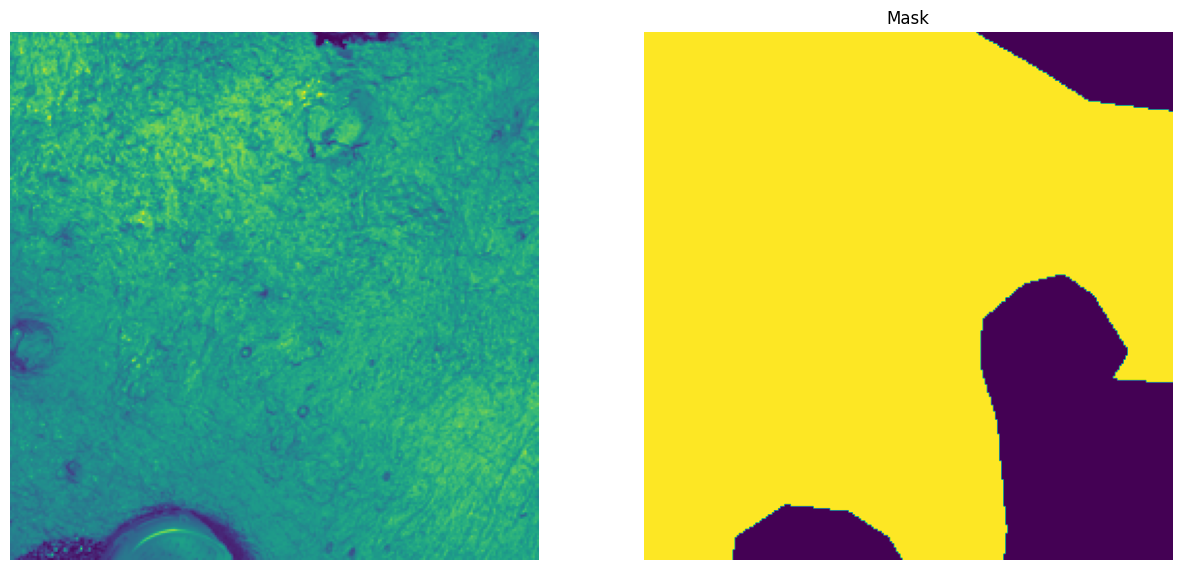

In [7]:
# Check if training data looks all right by grabbing some random images and their correponding masks
ix = np.random.randint(len(Image_train))

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# img = imread(os.path.join(TRAIN_PATH + '/images/', train_ids[ix]))

axes[0].imshow(Image_train[ix])
axes[0].axis('off')

axes[1].imshow(np.squeeze(Label_train[ix]))
axes[1].set_title('Mask')
axes[1].axis('off')

plt.show()

In [8]:
# Split train and valid
# Image_train, Image_valid, Label_train, Label_valid = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

# print (f"There are {len(Image_train)} images for training and {len(Image_valid)} images for validation")
# print (f"There are {len(Label_train)} labels for training and {len(Label_valid)} labels for validation")

In [9]:
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 1, 
                  width_shift_range = 0.02, 
                  height_shift_range = 0.02, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.1],  
                  horizontal_flip = False, 
                  vertical_flip = False,
                  fill_mode = 'nearest',
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def train_gen(batch_size = 16, seed = None):
    # {'img': X_train, 'feat': X_feat_train}, y_train,
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        batch_count = Image_train.shape[0]//batch_size
        batch_id = np.random.permutation(range(0, Image_train.shape[0]-batch_size, batch_size))
        for c_idx in batch_id:
            g_x = image_gen.flow(Image_train[c_idx:(c_idx+batch_size)], batch_size = batch_size, seed = seed, shuffle=False)
            g_y = label_gen.flow(Label_train[c_idx:(c_idx+batch_size)], batch_size = batch_size, seed = seed, shuffle=False)
            yield next(g_x)/255.0, next(g_y)

In [10]:
# Custom Metrics
 
from tensorflow.keras import backend as K

# This one is copied from online and does not yet work
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return coef

# I wrote this one to debug ones I found online
def iou(y_true, y_pred):
    inter = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    union = K.sum(K.round(y_true)) + K.sum(K.round(y_pred)) - inter
    iou = (inter + 1e-15) / (union + 1e-15)
    iou = K.cast(iou, tf.float32)
    return iou

# The following metrics are taken from https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)

# matthews_correlation_coefficient
def mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def equal_error_rate(y_true, y_pred):
    n_imp = tf.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer

In [11]:
def unet(pretrained_weights=None, input_size=(256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    # model.compile(optimizer = Adam(learning_rate = .00001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # model.compile(optimizer=Adam(learning_rate=.00001), loss='binary_crossentropy', metrics=[iou])
    # model.compile(optimizer=Adam(learning_rate=.00001), loss='binary_crossentropy', metrics=[dice_coef])
    model.compile(optimizer = Adam(learning_rate = .00001), loss = 'binary_crossentropy', metrics = [mcc])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


In [12]:
# base_folder = '/home/shannon/local/Source/Python/bm_study/' + run_name
# source_images = base_folder + '/train'

# # Create the augmented images directory if it doesn't exist
# augmented_images = os.path.join(base_folder + '/train', 'aug')
# os.makedirs(augmented_images, exist_ok=True)
# delete_images(augmented_images)

In [13]:
# seems like steps and batch size are inversely related
# smaller batch needs more steps

tf.random.set_seed(300)

model = unet()
batch_size = 16
epochs = 30
steps_per_epoch = 500

# model_checkpoint = ModelCheckpoint(f'unet_bm_{run_name}.keras', monitor='val_iou', verbose=1, save_best_only=True)
model_filename = os.path.join(root_path, run_name, f'unet_images_{run_name}.keras')
model_checkpoint = ModelCheckpoint(model_filename, monitor='val_mcc', verbose=1, mode='max', save_best_only=True)
history = model.fit(train_gen(batch_size), 
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(Image_valid / 255.0, Label_valid),
                    callbacks=[model_checkpoint])

# Checkpoint does the best model save so skip this
# model.save(f'unet_bm_small_steps{run_name}.keras')

# But do save the history
pickle_filename = os.path.join(root_path, run_name, f'history_dict_{run_name}.pkl')
with open(pickle_filename, 'wb') as file:
    pickle.dump(history.history, file)

2024-08-30 15:27:58.458859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22410 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:73:00.0, compute capability: 7.5


Epoch 1/30


I0000 00:00:1725024484.038577  107792 service.cc:146] XLA service 0x75876800ac90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725024484.038640  107792 service.cc:154]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2024-08-30 15:28:04.193891: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 15:28:04.838878: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-30 15:28:15.574320: W external/local_tsl/tsl/framework/bfc_allocator.cc:363] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.6812 - mcc: 0.0278
Epoch 1: val_mcc improved from -inf to 0.34109, saving model to /home/shannon/local/Source/Python/bm_study/unet/run_unet_images_01/unet_images_run_unet_images_01.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 232s 388ms/step - loss: 0.6812 - mcc: 0.0279 - val_loss: 0.6494 - val_mcc: 0.3411
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 0.5930 - mcc: 0.3451
Epoch 2: val_mcc improved from 0.34109 to 0.37216, saving model to /home/shannon/local/Source/Python/bm_study/unet/run_unet_images_01/unet_images_run_unet_images_01.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 181s 363ms/step - loss: 0.5929 - mcc: 0.3452 - val_loss: 0.6246 - val_mcc: 0.3722
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 0.5398 - mcc: 0.4295
Epoch 3: val_mcc did not improve from 0.37216
500/500 ━━━━━━━━━━━━━━━━━━━━ 179s 357ms/step - loss: 0.5398 - mcc: 0.4295 - val_loss: 0.6203 - val_mcc: 0.3600
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [20]:
# Test by looping through the complete set of test images and comparing the predicted mask with the actual mask
# for each image, predict the mask and save it to images/predictions
# for each image, compare the predicted mask with the actual mask and calculate the IoU
# save the result with the IoU as a prefix to the filename

model = load_model(os.path.join(root_path, run_name, f'unet_images_{run_name}.keras'), custom_objects={'mcc': mcc})

test_path = os.path.join(root_path, run_name, "test/images")
test_files = [f for f in os.listdir(test_path) if f.endswith('.png')]

mask_path = os.path.join(root_path, run_name, "test/labels")

results_path = os.path.join(root_path, run_name, "predictions_ranked")
os.makedirs(results_path, exist_ok=True)


def image_prep(filename, target_size=(256, 256), flag_multi_class=False, as_gray=True):
    img = imread(filename, as_gray=as_gray)
    img = img / 255.0
    img = trans.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,)) if (not flag_multi_class) else img
    img = np.reshape(img, (1,) + img.shape)
    return img

def convert_and_color(img, clr):
    new_image = np.dstack((img, img, img))
    new_image[:,:,0] = new_image[:,:,0] * clr[0]
    new_image[:,:,1] = new_image[:,:,1] * clr[1]
    new_image[:,:,2] = new_image[:,:,2] * clr[2]
    new_image = Image.fromarray(new_image.astype(np.uint8)).convert('RGBA')
    pred_transparency = img.copy()
    pred_transparency[pred_transparency > 0] = 30
    new_image.putalpha(Image.fromarray(pred_transparency).convert('L'))
    # new_image = new_image.resize((512, 512))
    return new_image

for file_name in test_files:
    # img = io.imread(os.path.join(test_path, file_name), as_gray=True)
    img = image_prep(os.path.join(test_path, file_name))

    # run model.predict on the image
    results = model.predict(img, verbose=1)
    
    # Force the results to 0 and 1 (better would be to look at different thresholds for this model)
    results[results < 0.5] = 0
    results[results >= 0.5] = 1

    # load the mask for this image
    mask_file = os.path.join(mask_path, file_name)
    mask = image_prep(mask_file)

    # compare the predicted mask with the actual mask and calculate the accuracy
    intersection = np.logical_and(mask.flatten(), results.flatten())
    union = np.logical_or(mask.flatten(), results.flatten())
    if np.sum(union) == 0:
        iou_score = 0
    else:
        iou_score = np.sum(intersection) / np.sum(union)

    pred = np.squeeze(results, axis=0).squeeze()  #remove batch axis (1,256,256,1) => (256,256,1) => (256,256)
    original = np.squeeze(img, axis=0).squeeze()     #remove batch axis (1,256,256,1) => (256,256,1) => (256,256)
    mask = np.squeeze(mask, axis=0).squeeze()     #remove batch axis (1,256,256,1) => (256,256,1) => (256,256)

    original_with_pred_mask = Image.open(os.path.join(test_path, file_name)).convert('RGBA')
    pred_mask = convert_and_color(pred, (255, 0, 0))
    original_with_pred_mask.paste(pred_mask, (0, 0), pred_mask)

    original_with_org_mask = Image.open(os.path.join(test_path, file_name)).convert('RGBA')
    org_mask = convert_and_color(mask, (0, 255, 0))
    original_with_org_mask.paste(org_mask, (0, 0), org_mask)

    # save these files in a folder called ranked_predictions
    # create a new filename by adding IoU as a two digit number to the start of the original filename
    new_file_name = "{:02d}_{}".format(int(iou_score * 100), file_name)
    new_file_path = os.path.join(results_path, new_file_name.replace('.png', '_predict.png'))
    original_with_pred_mask.convert('RGB').save(new_file_path)
    new_file_path = os.path.join(results_path, new_file_name.replace('.png', '_original.png'))
    original_with_org_mask.convert('RGB').save(new_file_path)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

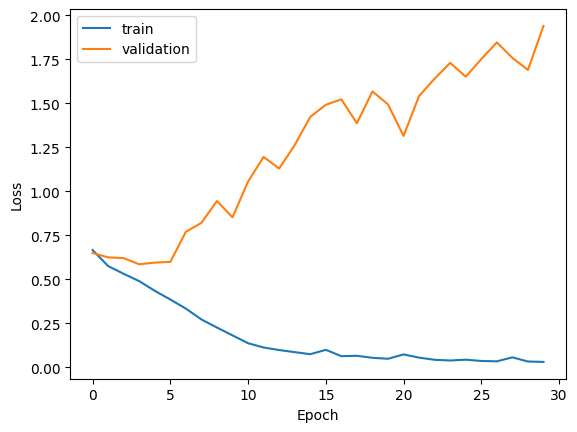

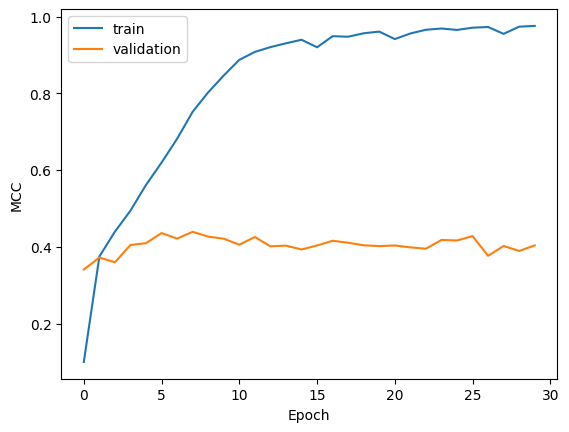

In [21]:
# Create loss and accuracy plots for train and validation data
# The history is in the history object

# Plot the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(root_path, run_name, 'loss_plot.png'))
plt.show()

# Plot the accuracy
plt.plot(history.history['mcc'], label='train')
plt.plot(history.history['val_mcc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MCC')
plt.legend()
plt.savefig(os.path.join(root_path, run_name, 'mcc_plot.png'))
plt.show()
